In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True, progress_bar=True, low_memory=True):
        
        # This will tell our odometry function if handler contains lidar info
        self.lidar = lidar
        # This will tell odometry functin how to access data from this object
        self.low_memory = low_memory
        
        # Set file paths and get ground truth poses
        self.seq_dir = './dataset/sequences/{}/'.format(sequence)
        self.poses_dir = './dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get names of files to iterate through
        self.left_image_files = sorted(os.listdir(self.seq_dir + 'image_0'))
        self.right_image_files = sorted(os.listdir(self.seq_dir + 'image_1'))
        self.velodyne_files = sorted(os.listdir(self.seq_dir + 'velodyne'))
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        if self.low_memory:
            # Will use generators to provide data sequentially to save RAM
            # Use class method to set up generators
            self.reset_frames()
            # Store original frame to memory for testing functions
            self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                               + self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                               + self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                    dtype=np.float32, 
                                                    count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            # If RAM is not a concern (>32GB), pass low_memory=False
            if progress_bar:
                import progressbar
                bar = progressbar.ProgressBar(max_value=self.num_frames)
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir + 'image_0/' + name_left))
                self.images_right.append(cv2.imread(self.seq_dir + 'image_1/' + name_right))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], 
                                             dtype=np.float32, 
                                             count=-1).reshape([-1,4])
                    self.pointclouds.append(pointcloud)
                if progress_bar:
                    bar.update(i+1)
                
            self.imheight = self.images_left[0].shape[0]
            self.imwidth = self.images_left[0].shape[1]
            # Keep consistent instance variable names as when using low_memory
            self.first_image_left = self.images_left[0]
            self.first_image_right = self.images_right[0]
            self.second_image_left = self.images_left[1]
            if self.lidar:
                self.first_pointcloud = self.pointclouds[0]
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [3]:
handler = Dataset_Handler('00')

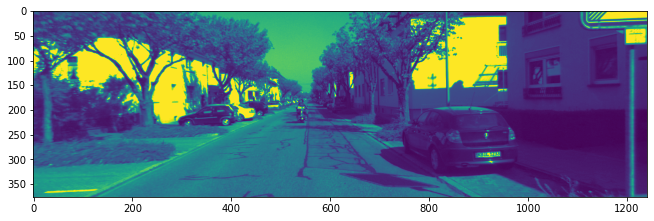

In [4]:
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);

In [5]:
handler.first_image_left.shape

(376, 1241)

In [6]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size)
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 1 * block_size ** 2,
                                        P2 = 32 * 1 * block_size ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
        
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)
        
    return disp_left

Time to compute disparity map using StereoBM 0:00:00.010712


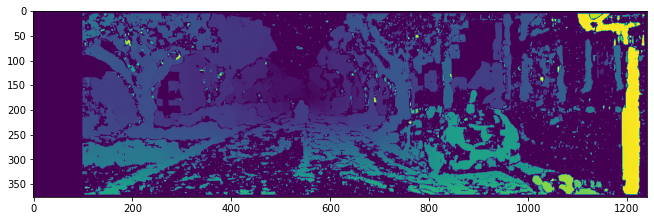

In [7]:
disp = compute_left_disparity_map(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM 0:00:00.031052


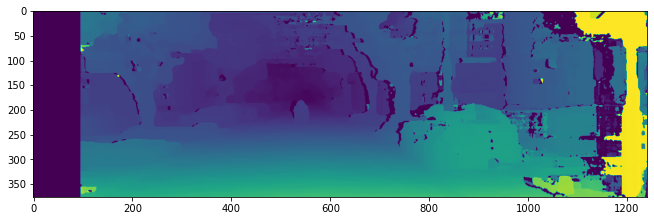

In [8]:
disp = compute_left_disparity_map(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [9]:
disp[0, 0]

-1.0

In [10]:
disp[disp > 0].min()

0.5625

In [11]:
handler.P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [12]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P1)
print(k)
print(r)
print((t / t[3]).round(4))

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [13]:
def decompose_projection_matrix(p):
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [14]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    
    if rectified:
        b = t_right[0] - t_left[0]
    else:
        b = t_left[0] - t_right[0]
        
    f = k_left[0][0]
    
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [15]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

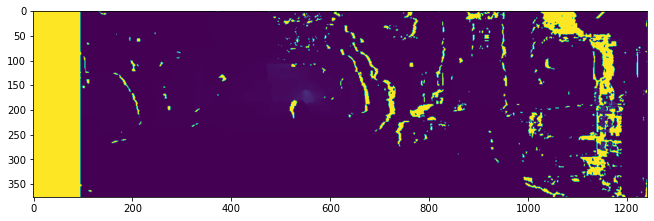

In [16]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.grid(False)
plt.imshow(depth);

In [17]:
depth[0, 0]

3861.447942459941

In [18]:
depth.max()

3861.447942459941

In [19]:
for i, pixel in enumerate(depth[0]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


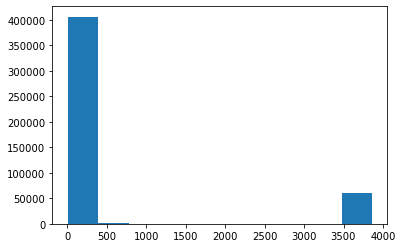

In [20]:
plt.hist(depth.flatten());

In [21]:
depth.shape

(376, 1241)

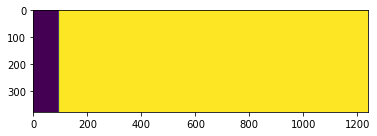

In [22]:
mask = np.zeros(depth.shape, dtype=np.uint8)
ymax = depth.shape[0]
xmax = depth.shape[1]
cv2.rectangle(mask, (96, 0), (xmax, ymax), (255), thickness=-1)
plt.imshow(mask);

In [23]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False,
                   rectified=True):
    # Compute disparity map
    disp = compute_left_disparity_map(img_left,
                                      img_right,
                                      matcher=matcher,
                                      rgb=rgb,
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

Time to compute disparity map using StereoSGBM 0:00:00.025066


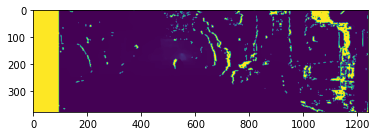

In [24]:
depth = stereo_2_depth(handler.first_image_left,
                       handler.first_image_right,
                       handler.P0,
                       handler.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(depth)

In [25]:
handler.first_pointcloud.shape

(124668, 4)

In [26]:
pcloud = handler.first_pointcloud
print('full pcloud shape', pcloud.shape)
trimmed_pcloud = pcloud[pcloud[:, 0] > 0]
print('trimmed pcloud shape', trimmed_pcloud.shape)

full pcloud shape (124668, 4)
trimmed pcloud shape (63141, 4)


In [27]:
handler.Tr.round(4)

array([[ 4.000e-04, -1.000e+00, -8.100e-03, -1.200e-02],
       [-7.200e-03,  8.100e-03, -9.999e-01, -5.400e-02],
       [ 1.000e+00,  5.000e-04, -7.200e-03, -2.922e-01]])

In [28]:
trimmed_pcloud.shape

(63141, 4)

In [29]:
hom_pcloud = np.hstack([trimmed_pcloud[:, :3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz = handler.Tr.dot(trimmed_pcloud.T)
#cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = handler.P0.dot(cam_xyz)
projection /= projection[2]
projection[:, :5].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ]])

In [30]:
hom_pcloud = np.hstack([trimmed_pcloud[:, :3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz = handler.Tr.dot(trimmed_pcloud.T)
cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = handler.P0.dot(cam_xyz)
projection[:, :5].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ]])

In [31]:
pixel_coords = np.round(projection, 0).T.astype('int')
pixel_coords[:5]

array([[607, 153,   1],
       [605, 153,   1],
       [602, 153,   1],
       [594, 154,   1],
       [592, 154,   1]])

Time to compute disparity map using StereoSGBM 0:00:00.030619


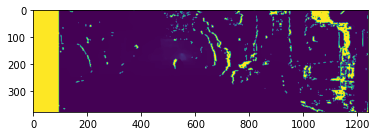

In [32]:
stereo_depth = stereo_2_depth(handler.first_image_left,
                       handler.first_image_right,
                       handler.P0,
                       handler.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(depth)

In [33]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:, 3]
    # Make pointcloud homogeneous (X, Y, Z, 1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform points into 3D coordinate frame of camera
    cam_xyz = Tr.dot(pointcloud.T)
    # Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    depth = cam_xyz[2].copy()
    
    cam_xyz /= cam_xyz[2]    
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0))
    
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]
    
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
        
    return render

In [34]:
render = pointcloud2image(handler.first_pointcloud, 
                          handler.imheight,
                          handler.imwidth,
                          handler.Tr,
                          handler.P0
                         )

In [35]:
render.shape

(376, 1241)

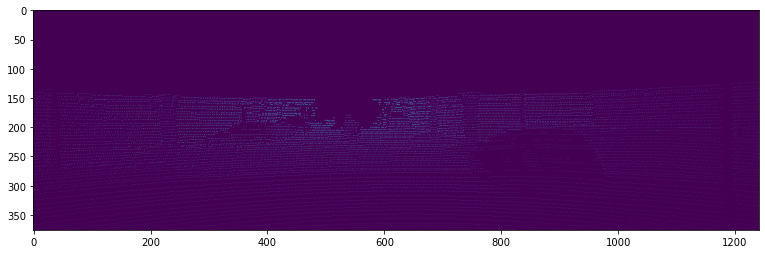

In [36]:
plt.figure(figsize=(13,5))
plt.imshow(render)

In [37]:
handler.imheight

376

In [38]:
for i, d in enumerate(stereo_depth[200:, :].flatten()):
    if render[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d, 'Lidar Depth:', render[200:, :].flatten()[i])
    if i > 1000:
        break

Stereo Depth: 24.040143190661475 Lidar Depth: 25.08251557273636
Stereo Depth: 36.99590898203592 Lidar Depth: 38.18529319193908
Stereo Depth: 37.67266341463414 Lidar Depth: 38.15661260397033
Stereo Depth: 37.67266341463414 Lidar Depth: 38.04491130916553
Stereo Depth: 38.13775802469135 Lidar Depth: 38.22929779114657
Stereo Depth: 38.37463850931676 Lidar Depth: 37.93287208133164
Stereo Depth: 38.61447999999999 Lidar Depth: 37.970212888663504
Stereo Depth: 38.61447999999999 Lidar Depth: 38.78230455441224
Stereo Depth: 39.10327088607594 Lidar Depth: 43.35304297366147
Stereo Depth: 52.80612649572648 Lidar Depth: 43.92954268130661
Stereo Depth: 56.681805504587146 Lidar Depth: 52.296451988896685
Stereo Depth: 57.20663703703703 Lidar Depth: 53.01673964440458
Stereo Depth: 57.20663703703703 Lidar Depth: 53.154098455093575
Stereo Depth: 57.741278504672884 Lidar Depth: 53.17143027237011
Stereo Depth: 57.741278504672884 Lidar Depth: 53.19275972156244
Stereo Depth: 57.741278504672884 Lidar Depth: 53

In [39]:
pcloud_frames = (pointcloud2image(next(handler.pointclouds),
                                  handler.imheight,
                                  handler.imwidth,
                                  handler.Tr,
                                  handler.P0)
                 for i in range(handler.num_frames))

#poses = (gt for gt in handler.gt)

In [40]:
%matplotlib tk

In [41]:
handler.gt[10].round(4)

array([[ 9.9980e-01,  5.0000e-03, -2.0700e-02, -4.6870e-01],
       [-5.3000e-03,  9.9990e-01, -1.1500e-02, -2.8380e-01],
       [ 2.0600e-02,  1.1600e-02,  9.9970e-01,  8.5829e+00]])

In [42]:
handler.reset_frames()
poses = (gt for gt in handler.gt)

In [43]:
xs = []
ys = []
zs = []
compute_times = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-20, azim=270)
ax.plot(handler.gt[:, 0, 3], handler.gt[:, 1, 3], handler.gt[:, 2, 3], c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

stereo_l = handler.images_left
stereo_r = handler.images_right

for i in range(handler.num_frames // 50):
    img_l = next(stereo_l)
    img_r = next(stereo_r)
    start = datetime.datetime.now()
    disp = compute_left_disparity_map(img_l, img_r, matcher='sgbm')
    disp /= disp.max()
    #disp = 1 - disp
    disp = (disp*255).astype('uint8')
    #disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud = next(pcloud_frames)
    pcloud /= pcloud.max()
    pcloud = (pcloud*255).astype('uint8')
    
    
    gt = next(poses)
    xs.append(gt[0, 3])
    ys.append(gt[1, 3])
    zs.append(gt[2, 3])
    plt.plot(xs, ys, zs, c='chartreuse')
    plt.pause(0.000000000000000001)
    cv2.imshow('camera', img_l)
    cv2.imshow('disparity', disp)
    cv2.imshow('lidar', pcloud)
    cv2.waitKey(1)
    
    end = datetime.datetime.now()
    compute_times.append(end-start)
    
plt.close()
cv2.destroyAllWindows()

In [44]:
plt.close()

In [45]:
def extract_features(image, detector='sift', mask=None):
    
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [46]:
def match_features(des1, des2, matching='BF', detector='sift', sort=False, k=2):
    
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = matcher.knnMatch(des1, des2, k=k)
        
    if sort:
        matches = sorted(matches, key=lambda x: x[0].distance)
        
    return matches

In [47]:
def visualize_matches(image1, kp1, image2, kp2, match):
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [48]:
def filter_matches_distance(matches, dist_threshold=0.5):
    filtered_matches = []
    for m, n in matches:
        if m.distance <= dist_threshold * n.distance:
            filtered_matches.append(m)
            
    return filtered_matches

In [49]:
%matplotlib inline

Number of matches before filtering:  500
Number of matches after filtering:  19
Time to match and filter:  0:00:00.034804


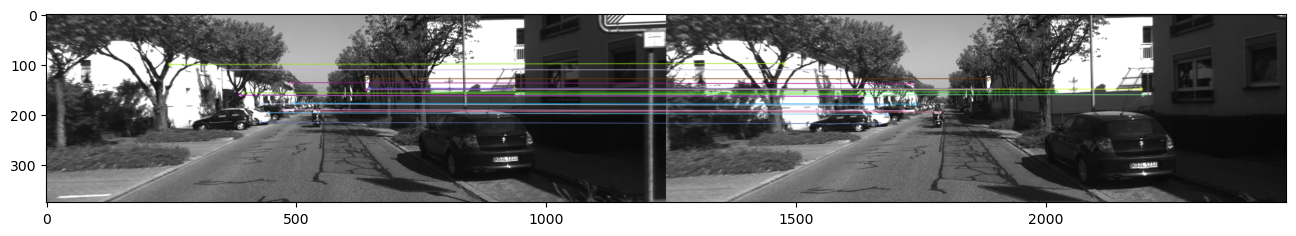

In [50]:
# Using the orb features/descriptors
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
start = datetime.datetime.now()
kp0, des0 = extract_features(image_left, 'orb', mask)
kp1, des1 = extract_features(image_plus1, 'orb', mask)
matches = match_features(des0, des1, matching='BF', detector='orb', sort=False)
print('Number of matches before filtering: ', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering: ', len(matches))
end = datetime.datetime.now()
print('Time to match and filter: ', end-start)
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [51]:
kp1[0].pt

(215.0, 123.0)

In [52]:
def estimate_motion(matches, kp1, kp2, k, depth1, max_depth=3000):
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    
    object_points = np.zeros((0, 3))
    delete = []
    
    for i, (u, v) in enumerate(image1_points):
        z = depth1[int(round(v)), int(round(u))]
        
        if z > max_depth:
            delete.append(i)
            continue
            
        x = z * (u - cx) / fx
        y = z * (v - cy) / fy
        object_points = np.vstack([object_points, np.array([x, y, z])])
        #object_points = np.vstack([obeject_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])
        
    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points

In [53]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)
k

array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])

In [54]:
rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, k, depth)
print("Rotation Matrix:")
print(rmat.round(4))
print("Translation Vector:")
print(tvec.round(4))

Rotation Matrix:
[[ 1.      0.002   0.0034]
 [-0.002   1.      0.0029]
 [-0.0034 -0.0029  1.    ]]
Translation Vector:
[[-0.0086]
 [-0.0196]
 [-0.7005]]


In [55]:
transformation_matrix = np.hstack([rmat, tvec])
print(transformation_matrix.round(4))

[[ 1.      0.002   0.0034 -0.0086]
 [-0.002   1.      0.0029 -0.0196]
 [-0.0034 -0.0029  1.     -0.7005]]


In [56]:
print(handler.gt[1].round(4))

[[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


In [57]:
hom_trans_mat = np.eye(4)
hom_trans_mat

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [58]:
tvec

array([[-0.00855439],
       [-0.01964685],
       [-0.70047737]])

In [59]:
hom_trans_mat[:3, :3] = rmat
hom_trans_mat[:3, 3] = tvec.T
hom_trans_mat.round(4)

array([[ 1.    ,  0.002 ,  0.0034, -0.0086],
       [-0.002 ,  1.    ,  0.0029, -0.0196],
       [-0.0034, -0.0029,  1.    , -0.7005],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [60]:
(np.linalg.inv(hom_trans_mat))

array([[ 0.99999204, -0.00204789, -0.0034245 ,  0.0061153 ],
       [ 0.0020381 ,  0.99999384, -0.00285805,  0.01766217],
       [ 0.00343033,  0.00285104,  0.99999005,  0.70055576],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [61]:
print(handler.gt[1].round(4))

[[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


In [62]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None,
                    stereo_matcher='sgbm', mask=None, subset=None, plot=False):
    # Determine if handler has lidar data
    lidar = handler.lidar
    
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector),
                                                                  matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish a homogeneous transformation matrix. First pose is identity
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
        
    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        start = datetime.datetime.now()
        
        if handler.low_memory:
            image_left = image_plus1
            image_plus1 = next(handler.images_left)
            image_right = next(handler.images_right)
        else:
            image_left = handler.images_left[i]
            image_plus1 = handler.images_left[i+1]
            image_right = handler.images_right[i]
            
        depth = stereo_2_depth(image_left,
                               image_right,
                               P0=handler.P0,
                               P1=handler.P1,
                               matcher=stereo_matcher
                              )
        
        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            
            lidar_depth = pointcloud2image(pointcloud,
                                           imheight=imheight,
                                           imwidth=imwidth,
                                           Tr=handler.Tr,
                                           P0=handler.P0
                                          )
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]
            
        # Get keypoints and descriptors for left camera image of two sequential frames
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in two subsequent frames
        matches_unfilt = match_features(des0, 
                                        des1,
                                        matching=matching,
                                        detector=detector
                                       )
        #print('Number of features before filtering: ', len(matches_unfilt))
        
        # Filter matches if a distance threshold is provided by user
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        
        #print('Number of features after filtering: ', len(matches))
        #print('Length of kp0:', len(kp0))
        #print('Length of kp1:', len(kp1))
            
        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches,
                                                               kp0,
                                                               kp1,
                                                               k_left,
                                                               depth
                                                              )
        
        # Create a blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:
        plt.close()
        
    return trajectory

In [63]:
%matplotlib tk

In [64]:
plt.close()

In [ ]:
trajectory_test = visual_odometry(handler, 
                                  detector='sift',
                                  matching='BF',
                                  filter_match_distance=0.3,
                                  stereo_matcher='sgbm',
                                  mask=mask,
                                  subset=None,
                                  plot=True
                                 )

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.3*distance
Improving stereo depth estimation with lidar data
Time to compute frame 1: 0:00:00.258383
Time to compute frame 2: 0:00:00.269883
Time to compute frame 3: 0:00:00.263400
Time to compute frame 4: 0:00:00.266211
Time to compute frame 5: 0:00:00.269411
Time to compute frame 6: 0:00:00.285528
Time to compute frame 7: 0:00:00.268967
Time to compute frame 8: 0:00:00.300303
Time to compute frame 9: 0:00:00.257191
Time to compute frame 10: 0:00:00.253177
Time to compute frame 11: 0:00:00.249798
Time to compute frame 12: 0:00:00.253754
Time to compute frame 13: 0:00:00.245349
Time to compute frame 14: 0:00:00.258548
Time to compute frame 15: 0:00:00.245715
Time to compute frame 16: 0:00:00.240819
Time to compute frame 17: 0:00:00.251973
Time to compute frame 18: 0:00:00.256252
Time to compute frame 19: 0:00:00.253640
Time to compute frame 20: 0:00:00.24

In [ ]:
%matplotlib inline

In [ ]:
from jupyterthemes import jtplot
jtplot.style()

In [ ]:
plt.style.use('seaborn-whitegrid')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-40, azim=270)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
xs = handler.gt[:, 0, 3]
ys = handler.gt[:, 1, 3]
zs = handler.gt[:, 2, 3]
ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.plot(xs, ys, zs, label='Ground Truth')
xs = trajectory_test[:, 0, 3]
ys = trajectory_test[:, 1, 3]
zs = trajectory_test[:, 2, 3]
plt.plot(xs, ys, zs, c='orange', label='Estimated')
plt.legend()

In [ ]:
# Saving the test trajectory output for later:
np.save('tutorial_test_trajectory', trajectory_test)